# Last Spring Freeze Prediction for Midwestern Wheat Farming

This notebook was created Bayu Wilson for the purpose of predicting last day of spring freeze (LDSF) for midwestern wheat farmers. Specifically I am using data from a weather measurement station in Wyandotte County, Kansas. This is the same county of a farm that I have previously worked at.

I will be going through a data science project lifecycle in a pedagogical way. [Here's a helpful diagram of the lifecyle](https://www.sudeep.co/data-science/2018/02/09/Understanding-the-Data-Science-Lifecycle.html).

### Business Understanding
See README for details regarding why a midwestern wheat farmer would benefit from a reliable last spring freeze prediction.

### Data Mining

The data in this notebook was ordered from [NOAA's Climate Data Online tool](https://www.ncdc.noaa.gov/cdo-web/search). I selected "Daily Summaries", for dates between 1994 to 2024 in Wyandotte county in Kansas. [Here is the documentation for the dataset](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf)

These are the main quantities of interest

| Abbreviation | Full Form                         |
|--------------|-----------------------------------|
| DATE         | Date of observation               |
| PRCP         | Precipitation                     |
| TMAX         | Maximum Temperature               |
| TMIN         | Minimum Temperature               |
| TOBS         | Temperature at the Time of Observation |
| SNOW          |  snowfall |
| SNWD          |  snowfall depth  |



### Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Here I load the dataset and remove unnecessary columns and stations.

In [2]:
df = pd.read_csv("3809660.csv") # there are a lot of empty columns.
station_list = df["STATION"].unique() #only the sixth station has temperature data
mask = df["STATION"]==station_list[6] #USC00140957, Bonner Springs, KS
df=df[mask]
df["DATE"] = pd.to_datetime(df["DATE"])
useful_columns = ["DATE","TMIN","TMAX","TOBS","PRCP", "SNOW", "SNWD"]
df = df[useful_columns]

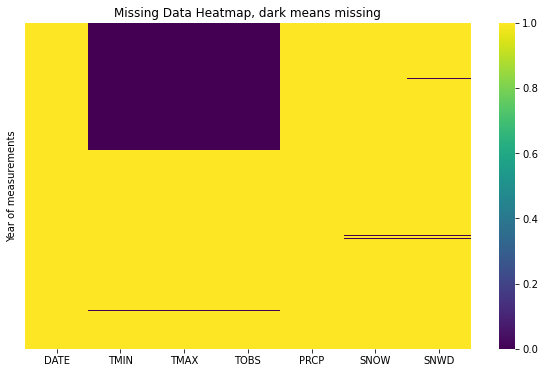

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(np.isfinite(df), cbar=True, cmap='viridis', yticklabels=False)
plt.ylabel("Year of measurements")
plt.title("Missing Data Heatmap, dark means missing");

There is clearly a large chunk of missing data. Let's remove those dates.

In [4]:
good_data_idx = df["DATE"][np.isfinite(df["TMIN"])].index[0]
print("data is not NAN for most of the dates after "+str(df["DATE"][good_data_idx]))

data is not NAN for most of the dates after 2004-12-01 00:00:00


In [5]:
assert len(df["DATE"]) == len(np.unique(df["DATE"])) #checking that there are no repeats

In [6]:
df_cleaned = df.loc[good_data_idx:].dropna().reset_index(drop=True)
df_cleaned["year"] = np.asarray(df_cleaned["DATE"].dt.strftime('%Y'),str)
df_cleaned["doy"] = np.asarray(df_cleaned["DATE"].dt.strftime('%j'),int) #doy=day of year
df_cleaned = df_cleaned[df_cleaned["year"] != '2004'] #2004 is missing dates prior to Dec. 1

In [7]:
# df_cleaned #you can check what data frame looks like by uncommenting this

In [8]:
# np.sum(~np.isfinite(df_cleaned[useful_columns])) #no more missing data!

In [9]:
def chunk_data(df): 
    #re-chunk data so that we can easily combine data at the end of one year with
    #the beginning of the next year (the span of the growing season)
    chunks = []
    for year in range(2005, 2021):  # Adjust the range as needed
        start_date = f'{year}-05-21'
        end_date = f'{year + 1}-05-20'
        chunk = df[(df.DATE >= start_date) & (df.DATE < end_date)].copy()
        chunk["year_offset"] = str(year)+"-"+str(year+1)
        chunks.append(chunk)
    return chunks

# Get the chunks
data_chunks = chunk_data(df_cleaned)
df_tot = pd.concat(data_chunks)
df_tot = df_tot[df_tot["doy"] != 366] #I don't care about leap years

Here I am calculating the average minimum temperature over years (2004 to 2021).

In [10]:
doy_temp_stats = df_tot.groupby('doy')['TMIN'].agg(['mean', 'std']).reset_index()
# offset = 365//1.5 #approximately number of days between summer solstice and the end of the year
offset = 225
doy_temp_stats["doy_offset"] = (doy_temp_stats["doy"]+offset)%366-offset
doy_temp_stats = doy_temp_stats.sort_values("doy_offset")

Nbins = 40
df_tot["doy_offset"] = (df_tot["doy"]+offset)%366-offset
bin_edges = pd.cut(df_tot["doy_offset"] , bins=Nbins)
binned_TMIN = df_tot["TMIN"].groupby(bin_edges).mean(numeric_only=True)
binned_TMIN_std = df_tot["TMIN"].groupby(bin_edges).std(numeric_only=True)
bin_centers = bin_edges.cat.categories.mid
# bin_centers = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2

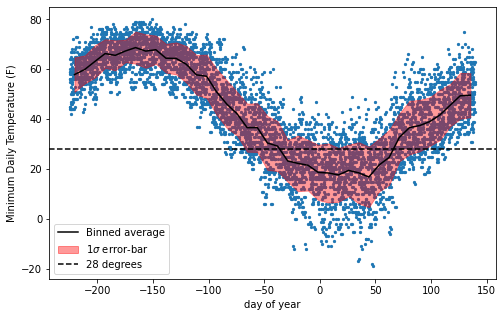

In [11]:
# df_tot["doy_offset"] = doy_offsetted
fig,ax = plt.subplots(1,figsize=(8,5))
plt.scatter(df_tot["doy_offset"],df_tot["TMIN"].values,s=5)
plt.plot(bin_centers,binned_TMIN,color='k',label="Binned average")
plt.fill_between(bin_centers,
                binned_TMIN-binned_TMIN_std,
                binned_TMIN+binned_TMIN_std,
                alpha=0.4,color='red',label=r'$1\sigma$ error-bar')
plt.axhline(28,ls='dashed',color='k',label="28 degrees")
plt.xlabel("day of year")
plt.ylabel("Minimum Daily Temperature (F)");
plt.legend();

Let's make sure that it is reasonable to use standard deviation to quantify the spread. We can check to see if the temperature distributions are gaussian. Below I show the temperature distributions for 4 of the bins.

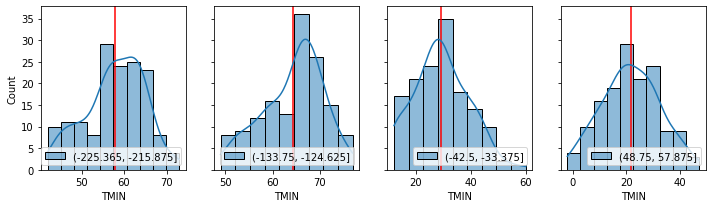

In [12]:
fig,ax = plt.subplots(ncols=4,figsize=(10,3),sharey=True)
for i in range(4):
    index_of_bin = i*10
    gauss_test_bin_edges = np.unique(bin_edges)[index_of_bin]
    gauss_test_TMIN = df_tot["TMIN"][(df_tot["doy_offset"]>gauss_test_bin_edges.left)&(
        df_tot["doy_offset"]<gauss_test_bin_edges.right)]
    mean = np.mean(gauss_test_TMIN)
    ax[i].axvline(mean,color='r')
    sns.histplot(gauss_test_TMIN,kde=True,ax=ax[i],label = str(gauss_test_bin_edges))
    ax[i].legend(loc="lower right")
plt.tight_layout()

That's close enough to gaussian for our purposes.

I am also curious what the typical standard deviations are.

From this we can say that a typical std of TMIN is 11 degrees F.


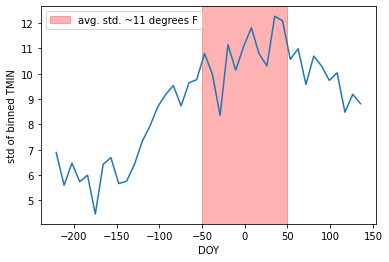

In [13]:
plt.plot(bin_centers,binned_TMIN_std)
plt.xlabel("DOY")
plt.ylabel("std of binned TMIN")
avg_std_TMIN = np.mean(binned_TMIN_std[(bin_centers>-50)&((bin_centers<50))])
plt.axvspan(-50,50,alpha=0.3,color='red',label = f"avg. std. ~{avg_std_TMIN:.0f} degrees F")
plt.legend()
print(f"From this we can say that a typical std of TMIN is {avg_std_TMIN:.0f} degrees F.");

## Solution 1: As simple as it gets
In this first solution, we simply use the average and standard deviation of the minimum temperature to find the last freeze day.

$$  max(\mathrm{DOY}) \ni \mu_{Tmin}-\sigma_{Tmin} \leq 28^\circ \mathrm{F}$$
Note that $\ni$ means "such that". This means that after this DOY, there will be at least an $\approx84\%$ chance that the temperature will be above $28^\circ \mathrm{F}$.

In [14]:
from scipy.interpolate import interp1d
interp_func_value = interp1d(bin_centers, binned_TMIN-binned_TMIN_std, kind='linear')

day_new = np.arange(0,135,1)
pred_last_day = day_new[interp_func_value(day_new)>28][0]
prob = 68/2+50

print(f"There is at least a {prob}% chance that the {pred_last_day}th day of the year "+
      "will have a minimum temperature greater \nthan 28 degrees.")
print("The 96rd day of 2025 is Monday, April 7.")

There is at least a 84.0% chance that the 94th day of the year will have a minimum temperature greater 
than 28 degrees.
The 96rd day of 2025 is Monday, April 7.


### How does this compare to the Farmers' Almanac?

[The Old Farmer's Almanac](https://www.almanac.com/gardening/frostdates/KS/Bonner%20Springs) says Bonner Springs, KS has a 30% chance of a last spring frost (32 degrees) on Apr 23, 2025. If I change the temperature threshold to 32 instead of 28 degrees in this work, the prediction changes to April 17. This is 6 day difference. I am not sure exactly how the almanac did their calculation so I can't comment on why these numbers are different. Note that the almanac uses the same NOAA dataset.

### How does this compare to the actual last freeze days?

The average LDSF is the 97.5th DOY.
The range of LDSF in this dataset is 70 to 115 DOY.


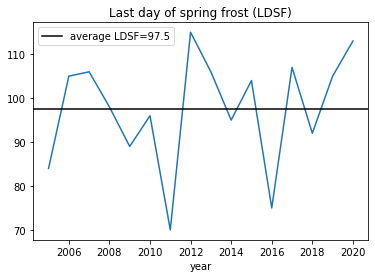

In [15]:
mask = (df_tot["TMIN"]<=28) & (df_tot["doy_offset"]>0)
filtered_df = df_tot[mask] 
yearly_last_frost_by_doy = filtered_df.groupby('year_offset')['doy'].max()
year_offset_list = yearly_last_frost_by_doy.index
year_list = np.asarray([year_offset_list[i][:4] for i in range(len(year_offset_list)) ],int)
simple_LDSF = np.mean(yearly_last_frost_by_doy.values)
plt.plot(year_list,yearly_last_frost_by_doy.values)
plt.axhline(simple_LDSF,color='k',label=f'average LDSF={simple_LDSF}')
plt.xlabel("year")
plt.legend()
plt.title("Last day of spring frost (LDSF)")

earliest_doy, latest_doy = min(yearly_last_frost_by_doy.values), max(yearly_last_frost_by_doy.values)

print(f"The average LDSF is the {simple_LDSF}th DOY.")
print(f"The range of LDSF in this dataset is {earliest_doy} to {latest_doy} DOY.")

Our simple solution predicted that the LDSF is the 96th DOY. This matches well with the actual LDSF calculated from the data. However, it is important to note that this approach does not capture the significant variation in the LDSF, which can span a range of up to 45 days. Clearly it would be useful to have a solution better than this.

## Solution 2: sinusoidal model based off of previous year's trends

The temperatures are obviously periodic and so it would be reasonable to try using a sinusoidal model to forecast the LDSF

In [16]:
import scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters 
    "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   
    # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    # guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])
    guess = np.array([guess_amp, 0., guess_offset])

    T = 365 #days
    w=2*np.pi/T
    f = w/(2.*np.pi)
    # def sinfunc(t, A, w, p, c):  
    def sinfunc(t, A, p, c):  
        return A * np.sin(w*t + p) + c
    
    # Perform curve fitting
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, p, c = popt
    
    # calculating uncertainties from covariance matrix
    perr = np.sqrt(np.diag(pcov))
    
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, #"period": 1./f, 
            "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}


For proof of concept, I first try this methodology with the 2007 to 2008 season.

(-100.0, 150.0)

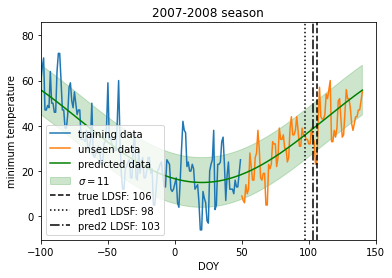

In [17]:
# season_index +=1
season_index=2
mask1 = (df_tot["year_offset"] == year_offset_list[season_index]) 

df_subset = df_tot[mask1].sort_values("doy_offset").copy()
mask2 = (df_subset["doy_offset"]<50)

fit_params = fit_sin(df_subset["doy_offset"].values[mask2],df_subset["TMIN"].values[mask2])
df_subset["fit_TMIN"] = fit_params['fitfunc'](df_subset["doy_offset"])

typical_std_TMIN = 11
pred_LDSF = np.max(df_subset[~mask2][df_subset["fit_TMIN"][~mask2]-typical_std_TMIN<=28]["doy_offset"])

plt.plot(df_subset["doy_offset"][mask2],df_subset["TMIN"][mask2],label="training data")
plt.plot(df_subset["doy_offset"][~mask2],df_subset["TMIN"][~mask2],label="unseen data")
plt.plot(df_subset["doy_offset"],df_subset["fit_TMIN"],label="predicted data",color='green')
plt.fill_between(df_subset["doy_offset"],
                 df_subset["fit_TMIN"]-typical_std_TMIN,
                 df_subset["fit_TMIN"]+typical_std_TMIN,
                 color='green',alpha=0.2,label=r'$\sigma=11$')
plt.xlabel("DOY")
plt.ylabel("minimum temperature")
plt.title(f"{year_offset_list[season_index]} season")

true_LDSF = yearly_last_frost_by_doy[year_offset_list[season_index]]

plt.axvline(true_LDSF,ls='--',color='k',label=f'true LDSF: {true_LDSF:d}')
# plt.axhline(28)
plt.axvline(simple_LDSF,ls='dotted',color='k',label=f'pred1 LDSF: {simple_LDSF:.0f}')
plt.axvline(pred_LDSF,ls='-.',color='k',label=f'pred2 LDSF: {pred_LDSF:d}')
plt.legend(ncols=1,loc="lower left")
plt.xlim(-100,150)
# print(pred_LDSF,true_LDSF, simple_LDSF);

We can quantify how well the predicted value is doing by using the percent difference

In [18]:
perc_diff = np.abs(true_LDSF-pred_LDSF)/(true_LDSF+pred_LDSF)*2*100
day_diff = np.abs(true_LDSF-pred_LDSF)
print(f"percent difference between truth and prediction is ~{perc_diff:.0f}%")
print(f"difference of days between truth and prediction is {day_diff} days")

percent difference between truth and prediction is ~3%
difference of days between truth and prediction is 3 days


### Now repeat this methodology on each season 

I fit a sin function (with fixed, 365 day period) to the data in a single growing season. The idea is that a season might be colder or hotter than an average season. Or perhaps the season's temperature pattern distribution is offset in time by a little bit. 

In [19]:
pred_list = []
true_list = []
for i in range(len(year_offset_list)):
    mask1 = (df_tot["year_offset"] == year_offset_list[i]) 

    df_subset = df_tot[mask1].sort_values("doy_offset").copy()
    mask2 = (df_subset["doy_offset"]<50)

    fit_params = fit_sin(df_subset["doy_offset"].values[mask2],df_subset["TMIN"].values[mask2])
    df_subset["fit_TMIN"] = fit_params['fitfunc'](df_subset["doy_offset"])

    typical_std_TMIN = 11
    pred_LDSF = np.max(df_subset[~mask2][df_subset["fit_TMIN"][~mask2]-typical_std_TMIN<=28]["doy_offset"])
    pred_list.append(pred_LDSF)
    
    true_LDSF = yearly_last_frost_by_doy[year_offset_list[i]]
    true_list.append(true_LDSF)
    # plt.axvline(true_LDSF,color='k')
    # plt.axvline(pred_LDSF)
    # plt.title(year_offset_list[i])
    # plt.plot(df_subset["doy_offset"],df_subset["TMIN"])
    # plt.plot(df_subset["doy_offset"],df_subset["fit_TMIN"])

In [20]:
day_diff_list_m1 = []
day_diff_list_m2 = []
for i in range(len(pred_list)):
    day_diff_list_m1.append((simple_LDSF-true_list[i]))
    day_diff_list_m2.append((pred_list[i]-true_list[i]))

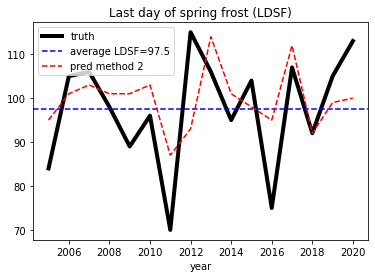

In [21]:
plt.plot(year_list,yearly_last_frost_by_doy.values,label='truth',color='k',lw=4)
plt.axhline(simple_LDSF,label=f'average LDSF={simple_LDSF}',ls='dashed',color='blue')
plt.plot(year_list,pred_list,label='pred method 2',ls='dashed',color='red')
plt.xlabel("year")
plt.legend()
plt.title("Last day of spring frost (LDSF)");

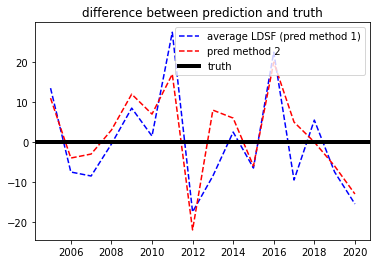

In [22]:
plt.plot(year_list,day_diff_list_m1,ls='dashed',color='blue',label=f'average LDSF (pred method 1)')
plt.plot(year_list,day_diff_list_m2,ls='dashed',color='red',label='pred method 2')
plt.axhline(0,lw=4,color='k',label="truth")
plt.title("difference between prediction and truth")
plt.legend();

In [23]:
avg_day_diff_m1 =  np.mean(np.abs(day_diff_list_m1))
avg_day_diff_m2 =  np.mean(np.abs(day_diff_list_m2))
percent_change = (1-avg_day_diff_m2/avg_day_diff_m1)*100
print("The sinusoidal model decreases the average LDSF residual from "+
      f"{avg_day_diff_m1:.1f} to {avg_day_diff_m2:.1f} days.")
print(f"This is a {percent_change:.1f}% decrease.")

The sinusoidal model decreases the average LDSF residual from 10.2 to 8.9 days.
This is a 12.3% decrease.


A 12% better understanding on the LDSF would be have a significant effect on the agriculture industry as it would better inform farmers on when they should take actions to prevent freeze damage on their crops.

## Solution 3: Univariate traditional time-series models: ARIMA/SARIMA
ARIMA is the autoregressive integrated moving average. It is a statistical analysis model that uses time series data to predict future trends. It is a form of regression analysis. "Autoregressive" means it uses past values to predict future values. "Integrated" means it differences the data to make it stationary (see more about this below). This algorithm uses past forecast errors from the "moving average" to help improve the model. 

ARIMA requires stationary data. This means that statistical properties (like mean, variance, and autocorrelation) remain constant over time. This means that there are no trends, seasonal effects, or other forms of systematic change. Many time-series datasets have trends and seasonal effects but there are ways to transform it to be stationary. One thing that can be done is differencing, detrending, and seasonal adjustment.

SARIMA means "Seasonal ARIMA". It adds a seasonal component which makes it suitable for data with repeating seasonal patterns (such as weather data). One major drawback about it that it adds more hyperparameters whose values are chosen somewhat subjectively and it is computationally expensive. For this simple analysis, it was taking much too long to train the SARIMA with daily frequency data so you will see that I actually decided to use weekly temperature data instead. 

MAJOR CAVEAT: I thinned out the dataset by taking the minimum temperature measurements every 7 days. I should've found the minimum temperature of all days in that week. Since this is just a proof-of-concept, exploratory project and the model takes a non-trivial amount of time to run, I've decided to just leave things as-is.

#### The SARIMA approach

I will use 4 years of weekly temperature data to train the SARIMA model. The model will then be used to forecast the temperatures for around 6 months afterwards. The goal is to predict the last day of spring frost, LDSF, where $T\leq28$ degrees F. In order to quantify its success of this model, I will simply be using the residual between the true and predicted LDSF in units of weeks. 

In [889]:
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

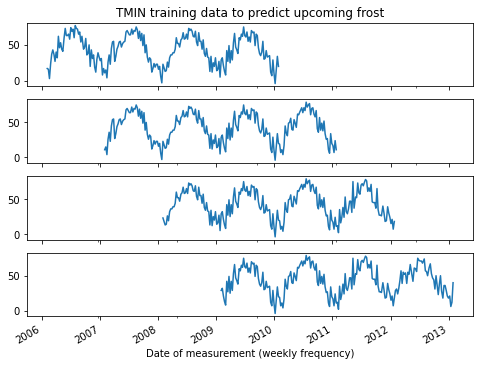

In [892]:
N = len(np.unique(df_tot['year_offset']))
lag_years = 4 #training 4 years beforehand
weekly_df = df_tot.iloc[::7].copy().reset_index(drop=True)
weekly_df.set_index("DATE",inplace=True)
starting_date = pd.to_datetime('2006-01-30')

nrows=4
fig,ax = plt.subplots(nrows=nrows,figsize=(8,6),sharex=True)
for i in range(N-lag_years):
    ending_date = starting_date + pd.Timedelta(days=365*lag_years)
    if i<nrows:
        weekly_df.loc[starting_date:ending_date]["TMIN"].plot(ax=ax[i])
    starting_date += pd.Timedelta(days=365)
ax[0].set_title("TMIN training data to predict upcoming freeze")
ax[-1].set_xlabel("Date of measurement (weekly frequency)");

In [620]:
### BEWARE THIS CELL TAKES A LONG TIME TO RUN ###
starting_date = pd.to_datetime('2006-01-30')
results_list = []
for i in range(N-lag_years):
    ending_date = starting_date + pd.Timedelta(days=365*lag_years)
    data = weekly_df.loc[starting_date:ending_date]["TMIN"]
    model=SARIMAX(data,order=(1,1,1),seasonal_order=(1,1,1,52))
    results=model.fit()
    results_list.append(results)
    starting_date += pd.Timedelta(days=365)

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91901D+00    |proj g|=  1.37030D-01

At iterate    5    f=  2.83281D+00    |proj g|=  1.31542D-02

At iterate   10    f=  2.81645D+00    |proj g|=  3.72476D-03

At iterate   15    f=  2.81522D+00    |proj g|=  3.45293D-03

At iterate   20    f=  2.81501D+00    |proj g|=  1.86070D-04

At iterate   25    f=  2.81497D+00    |proj g|=  4.10479D-04

At iterate   30    f=  2.81496D+00    |proj g|=  1.56026D-04

At iterate   35    f=  2.81496D+00    |proj g|=  6.56871D-05

At iterate   40    f=  2.81496D+00    |proj g|=  4.31958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95485D+00    |proj g|=  1.95219D-01

At iterate    5    f=  2.85007D+00    |proj g|=  1.50890D-02

At iterate   10    f=  2.82784D+00    |proj g|=  6.01367D-03

At iterate   15    f=  2.82635D+00    |proj g|=  1.24838D-03

At iterate   20    f=  2.82616D+00    |proj g|=  1.40820D-03

At iterate   25    f=  2.82607D+00    |proj g|=  5.94298D-04

At iterate   30    f=  2.82603D+00    |proj g|=  3.28195D-04

At iterate   35    f=  2.82602D+00    |proj g|=  2.47669D-05

At iterate   40    f=  2.82602D+00    |proj g|=  1.71100D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02847D+00    |proj g|=  2.21313D-01


 This problem is unconstrained.



At iterate    5    f=  2.91371D+00    |proj g|=  2.77067D-02

At iterate   10    f=  2.87599D+00    |proj g|=  1.03439D-02

At iterate   15    f=  2.87427D+00    |proj g|=  2.76166D-03

At iterate   20    f=  2.87402D+00    |proj g|=  9.58802D-04

At iterate   25    f=  2.87398D+00    |proj g|=  5.25598D-04

At iterate   30    f=  2.87396D+00    |proj g|=  5.84797D-04

At iterate   35    f=  2.87395D+00    |proj g|=  1.00842D-04

At iterate   40    f=  2.87395D+00    |proj g|=  3.85458D-05

At iterate   45    f=  2.87395D+00    |proj g|=  5.83278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     49   

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  3.06068D+00    |proj g|=  2.03008D-01

At iterate    5    f=  2.99232D+00    |proj g|=  1.76374D-02

At iterate   10    f=  2.98139D+00    |proj g|=  1.31644D-02

At iterate   15    f=  2.97825D+00    |proj g|=  1.61954D-03

At iterate   20    f=  2.97780D+00    |proj g|=  1.51271D-03

At iterate   25    f=  2.97770D+00    |proj g|=  8.79895D-04

At iterate   30    f=  2.97768D+00    |proj g|=  2.72394D-04

At iterate   35    f=  2.97767D+00    |proj g|=  2.55065D-04

At iterate   40    f=  2.97767D+00    |proj g|=  9.15553D-05

At iterate   45    f=  2.97767D+00    |proj g|=  2.17554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07045D+00    |proj g|=  2.71137D-01


 This problem is unconstrained.



At iterate    5    f=  2.99255D+00    |proj g|=  1.58786D-02

At iterate   10    f=  2.95789D+00    |proj g|=  5.40179D-02

At iterate   15    f=  2.95390D+00    |proj g|=  4.73383D-03

At iterate   20    f=  2.95344D+00    |proj g|=  2.36657D-03

At iterate   25    f=  2.95337D+00    |proj g|=  1.12607D-03

At iterate   30    f=  2.95335D+00    |proj g|=  5.06040D-04

At iterate   35    f=  2.95335D+00    |proj g|=  1.40423D-04

At iterate   40    f=  2.95335D+00    |proj g|=  2.94824D-04

At iterate   45    f=  2.95335D+00    |proj g|=  5.97533D-05


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.95335D+00    |proj g|=  1.61472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   1.615D-04   2.953D+00
  F =   2.9533459124660175     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  3.07995D+00    |proj g|=  2.53388D-01

At iterate    5    f=  3.00217D+00    |proj g|=  4.39670D-02

At iterate   10    f=  2.97644D+00    |proj g|=  1.43280D-02

At iterate   15    f=  2.97602D+00    |proj g|=  2.57917D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   6.111D-06   2.976D+00
  F =   2.9760206251649977     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09214D+00    |proj g|=  2.49962D-01


 This problem is unconstrained.



At iterate    5    f=  3.01049D+00    |proj g|=  6.05981D-02

At iterate   10    f=  2.95932D+00    |proj g|=  9.19491D-03

At iterate   15    f=  2.95682D+00    |proj g|=  3.10091D-03

At iterate   20    f=  2.95612D+00    |proj g|=  1.61679D-03

At iterate   25    f=  2.95610D+00    |proj g|=  1.73897D-03

At iterate   30    f=  2.95606D+00    |proj g|=  4.32645D-04

At iterate   35    f=  2.95605D+00    |proj g|=  2.31203D-04

At iterate   40    f=  2.95604D+00    |proj g|=  8.11474D-05

At iterate   45    f=  2.95604D+00    |proj g|=  1.25523D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     56   

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12010D+00    |proj g|=  3.05959D-01

At iterate    5    f=  3.02085D+00    |proj g|=  1.52490D-02

At iterate   10    f=  2.96728D+00    |proj g|=  4.15105D-02

At iterate   15    f=  2.96344D+00    |proj g|=  1.32316D-02

At iterate   20    f=  2.96123D+00    |proj g|=  2.20019D-03

At iterate   25    f=  2.96073D+00    |proj g|=  1.83246D-03

At iterate   30    f=  2.96064D+00    |proj g|=  6.01243D-05

At iterate   35    f=  2.96063D+00    |proj g|=  2.70167D-04

At iterate   40    f=  2.96062D+00    |proj g|=  5.82960D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08531D+00    |proj g|=  2.39409D-01

At iterate    5    f=  2.98607D+00    |proj g|=  8.11712D-02

At iterate   10    f=  2.96920D+00    |proj g|=  1.70473D-02

At iterate   15    f=  2.96813D+00    |proj g|=  2.42274D-04

At iterate   20    f=  2.96805D+00    |proj g|=  4.93136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   3.272D-07   2.968D+00
  F =   2.9680455515852295     

CONVERG

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07125D+00    |proj g|=  2.59204D-01

At iterate    5    f=  2.99474D+00    |proj g|=  1.56574D-02

At iterate   10    f=  2.94306D+00    |proj g|=  1.33171D-02

At iterate   15    f=  2.94248D+00    |proj g|=  5.91318D-03

At iterate   20    f=  2.94214D+00    |proj g|=  2.90039D-03

At iterate   25    f=  2.94210D+00    |proj g|=  2.10291D-04

At iterate   30    f=  2.94209D+00    |proj g|=  6.91278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02135D+00    |proj g|=  2.37840D-01

At iterate    5    f=  2.92807D+00    |proj g|=  7.14227D-02

At iterate   10    f=  2.91659D+00    |proj g|=  1.27236D-02

At iterate   15    f=  2.91580D+00    |proj g|=  5.64526D-04

At iterate   20    f=  2.91562D+00    |proj g|=  3.32685D-04

At iterate   25    f=  2.91554D+00    |proj g|=  3.63212D-04

At iterate   30    f=  2.91550D+00    |proj g|=  7.10258D-04

At iterate   35    f=  2.91549D+00    |proj g|=  2.55051D-04

At iterate   40    f=  2.91548D+00    |proj g|=  1.85378D-05

At iterate   45    f=  2.91548D+00    |proj g|=  6.19175D-05


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.91548D+00    |proj g|=  4.71450D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   4.714D-06   2.915D+00
  F =   2.9154837762732346     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97460D+00    |proj g|=  2.11199D-01


 This problem is unconstrained.



At iterate    5    f=  2.90198D+00    |proj g|=  6.70680D-02

At iterate   10    f=  2.88465D+00    |proj g|=  1.19700D-02

At iterate   15    f=  2.88195D+00    |proj g|=  3.67809D-03

At iterate   20    f=  2.87969D+00    |proj g|=  3.44648D-03

At iterate   25    f=  2.87907D+00    |proj g|=  6.31769D-04

At iterate   30    f=  2.87901D+00    |proj g|=  2.17209D-04

At iterate   35    f=  2.87900D+00    |proj g|=  4.60641D-05

At iterate   40    f=  2.87900D+00    |proj g|=  1.34933D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     50      1     0     0   2.971D-05   2.879D+00
  F =   2.87899954460

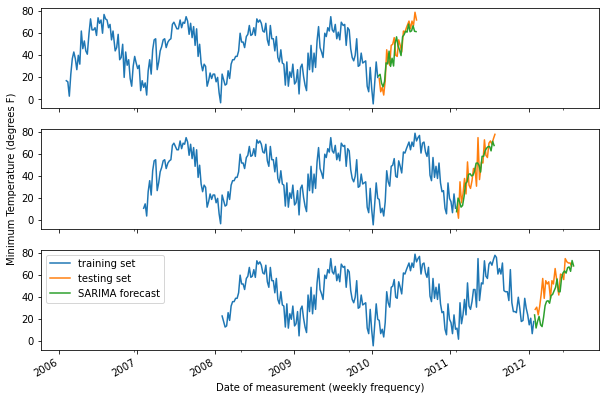

In [896]:
import warnings
warnings.filterwarnings("ignore",
                        message="No supported index is available. Prediction results will be " +
                        "given with an integer index beginning at `start`.")

train_starting_date = pd.to_datetime('2006-01-30')

nrows=3
fig,ax = plt.subplots(nrows=nrows,figsize=(10,7),sharex=True)

LDSF_test_list = []
LDSF_forecast_list = []
dates_forecast_list = []
for i in range(N-lag_years):
    trian_ending_date = train_starting_date + pd.Timedelta(days=365*lag_years)
    test_starting_date = trian_ending_date
    dates_forecast_list.append(test_starting_date)
    test_ending_date = test_starting_date  + pd.Timedelta(weeks=52//2)
    
    train_dates = weekly_df.loc[train_starting_date:trian_ending_date]["TMIN"]
    test_dates = weekly_df.loc[test_starting_date:test_ending_date]["TMIN"]
    
    forecast_dates = pd.date_range(start=test_starting_date, end=test_ending_date, freq='W')
    forecast_vals = results_list[i].forecast(steps=len(forecast_dates))
    
    LDSF_test = test_dates[test_dates<=28].index[-1]
    LDSF_test_list.append(LDSF_test)
    LDSF_forecast = forecast_dates[(forecast_vals<=28)&(forecast_dates<"2021-07-18")][-1]
    LDSF_forecast_list.append(LDSF_forecast)
    #plotting a few (not all)
    if i<nrows:
        train_dates.plot(ax=ax[i],label='training set')
        test_dates.plot(ax=ax[i],label='testing set')
        ax[i].plot(forecast_dates,forecast_vals,label='SARIMA forecast')
    train_starting_date += pd.Timedelta(days=365)
ax[-1].legend(loc='upper left')
ax[1].set_ylabel("Minimum Temperature (degrees F)")
ax[-1].set_xlabel("Date of measurement (weekly frequency)");

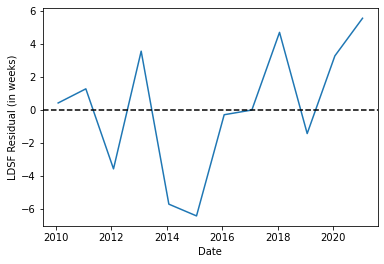

In [897]:
residuals = pd.Series(LDSF_test_list)-pd.Series(LDSF_forecast_list)
residuals = residuals.dt.days
plt.plot(pd.Series(dates_forecast_list),residuals/7)
plt.xlabel("Date")
plt.ylabel("LDSF Residual (in weeks)")
plt.axhline(0,color='k',ls='--')

In [887]:
avg_residual_SARIMA = np.mean(np.abs(residuals))/7
print(f"The average LDSF residual for the SARIMA method is {avg_residual_SARIMA:.0f} weeks")

The average LDSF residual for the SARIMA method is 3 weeks


This is obviously significantly worse than the first two methods. It goes to show that more complex solutions are not always better (especially when the data scientist isn't well versed in SARIMA models!)

## Solution 4: Machine learning models

In [ ]:
# avg_day_diff_m1 =  np.mean(np.abs(day_diff_list_m1))
# avg_day_diff_m2 =  np.mean(np.abs(day_diff_list_m2))
# percent_change = (1-avg_day_diff_m2/avg_day_diff_m1)*100
# print("The sinusoidal model decreases the average LDSF residual from "+
#       f"{avg_day_diff_m1:.1f} to {avg_day_diff_m2:.1f} days.")

In [853]:

# dates_forecast_list 
# len(LDSF_test_list)

array([Timedelta('3 days 00:00:00'), Timedelta('9 days 00:00:00'),
       Timedelta('-25 days +00:00:00'), Timedelta('25 days 00:00:00'),
       Timedelta('-40 days +00:00:00'), Timedelta('-45 days +00:00:00'),
       Timedelta('-2 days +00:00:00'), Timedelta('0 days 00:00:00'),
       Timedelta('33 days 00:00:00'), Timedelta('-10 days +00:00:00'),
       Timedelta('23 days 00:00:00'), Timedelta('39 days 00:00:00')],
      dtype=object)

2021-03-14 00:00:00


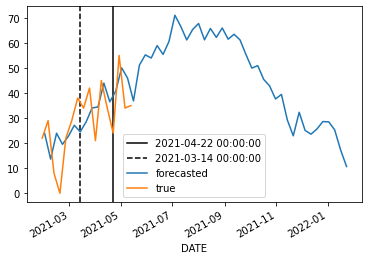

In [827]:
# train_dates.plot(label='training')
# test_dates.plot(label='true')

LDSF_test = test_dates[test_dates<=28].index[-1]
LDSF_forecast = forecast_dates[(forecast_vals<=28)&(forecast_dates<"2021-07-18")][-1]
plt.axvline(LDSF_test,color='k',label=LDSF_test)
plt.axvline(LDSF_forecast,color='k',label=LDSF_forecast,ls='dashed')

plt.plot(forecast_dates,forecast_vals,label='forecasted')
LDSF_forecast
test_dates.plot(label='true')

plt.legend()

print(LDSF_forecast)


In [818]:
forecast_dates < "2021-02-07"

DatetimeIndex(['2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18',
               '2021-04-25', '2021-05-02', '2021-05-09', '2021-05-16',
               '2021-05-23', '2021-05-30', '2021-06-06', '2021-06-13',
               '2021-06-20', '2021-06-27', '2021-07-04', '2021-07-11',
               '2021-07-18', '2021-07-25', '2021-08-01', '2021-08-08',
               '2021-08-15', '2021-08-22', '2021-08-29', '2021-09-05',
               '2021-09-12', '2021-09-19', '2021-09-26', '2021-10-03',
               '2021-10-10', '2021-10-17', '2021-10-24', '2021-10-31',
               '2021-11-07', '2021-11-14', '2021-11-21', '2021-11-28',
               '2021-12-05', '2021-12-12', '2021-12-19', '2021-12-26',
               '2022-01-02', '2022-01-09', '2022-01-16', '2022-01-23'],
              dtype='datetime64[ns]', freq='W-SUN')

In [891]:
# N = len(np.unique(df_tot['year_offset']))
# lag_years = 4
# offset_days = 255
# ranges = [(365*i+offset_days,365*(i+lag_years)+offset_days) for i in range(N-lag_years)]

# # TMIN_weekly = df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7]
# # days = np.arange(ranges[0][0],ranges[0][1],7)
# # weeks=days/7
# # plt.plot(days,TMIN_weekly)

# i=0
# start = ranges[i][1]//7-50
# end = ranges[i][1]//7+50

# TMIN_weekly = df_tot["TMIN"].values[ranges[i][0]:ranges[i][1]:7]
# days = np.arange(ranges[i][0],ranges[i][1],7)
# weeks = days/7
# plt.plot(days,TMIN_weekly)
# # plt.axvline(1711)

In [762]:
# forecast_start_date = ending_date
# forecast_end_date = forecast_start_date + pd.Timedelta(weeks=52//2)
# forecast_vals = results_list[i].predict(start=starting_date,end=ending_date,dynamic=True)
# forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='W')
# ax[i].plot(forecast_dates,forecast_vals)
# print(test_starting_date)

# print(test_starting_date)
# print(train_starting_date)
# ax[0].set_title("TMIN training data to predict upcoming frost");

# results_list[0].predict(start=52*3,end=300,dynamic=True).plot(ax=ax[0])

In [745]:
results_list[0].forecast(steps=52).values #.plot()

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


array([21.34961067, 22.75909698, 14.70883061, 11.45326621, 16.40031238,
       33.18838485, 32.19748261, 43.7739803 , 29.95420015, 37.37168383,
       30.30665377, 50.66026269, 56.73688014, 48.48541309, 44.77984048,
       39.75142245, 56.82598294, 58.6381504 , 61.8549461 , 60.96220155,
       68.26227359, 61.3071072 , 62.16228568, 66.81380756, 61.74018252,
       61.47411123, 61.84026825, 67.74695996, 66.79437456, 66.42638552,
       53.63535824, 59.38920176, 60.80419614, 48.3422024 , 42.48265236,
       44.08625572, 39.99824685, 46.65756015, 33.6567627 , 28.50384978,
       37.8474515 , 30.44821831, 26.49664818, 27.31051067, 12.23738732,
       14.69208542, 27.3134252 , 18.43352896,  6.75139289, 17.67613887,
       21.8572311 , 12.1969474 ])

In [721]:
# forecast_start_date = 
# pd.to_datetime('2010-01-01')+ pd.Timedelta(weeks=52//2)
# results_list[0].predict(start=pd.to_datetime('2007-01-01'),
#                         end=pd.to_datetime('2007-01-01')+ pd.Timedelta(weeks=52//2),
#                         dynamic=True)

In [710]:
pd.Timedelta(weeks=5)

Timedelta('35 days 00:00:00')

In [709]:
pd.date_range(start=starting_date, end=starting_date, freq='W')

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot: >

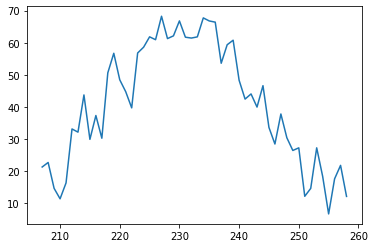

In [704]:
results_list[0].forecast(steps=52).plot()

In [699]:
 weekly_df.loc[starting_date:ending_date]["TMIN"]

DATE
2018-02-02     5.0
2018-02-09    22.0
2018-02-16    24.0
2018-02-23    27.0
2018-03-02    23.0
              ... 
2020-12-23    24.0
2020-12-30    28.0
2021-01-07    34.0
2021-01-14    29.0
2021-01-21    20.0
Name: TMIN, Length: 153, dtype: float64

In [695]:
results_list[0].predict(start=52*1,end=52*3,dynamic=True)

DATE
2007-02-07    19.501009
2007-02-14    18.500822
2007-02-21     5.502852
2007-02-28    25.501081
2007-03-07    39.501068
                ...    
2009-01-11    36.001225
2009-01-18    13.004654
2009-01-25    22.001840
2009-02-01    16.003284
2009-02-08    24.503615
Name: predicted_mean, Length: 105, dtype: float64

In [653]:
# weekly_df["TMIN"]
# results_list[0].predict(start=50,end=100,dynamic=True)
# results_list[i].predict(start=starting_date,end=ending_date,dynamic=True)
# weekly_df

In [631]:
start = 200#weeks
end = 300 #weeks 
# weekly_df["TMIN"].plot()
results_list[0].predict(start=start,end=end,dynamic=True)#.plot(color='orange')
# plt.xlim(pd.to_datetime('2009-01-01'),pd.to_datetime('2012-01-30'))
# plt.axvline(weekly_df.index[0] + pd.Timedelta(weeks=200),color='orange')

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


200    24.247303
201    24.561682
202    29.586979
203    17.062868
204    19.699543
         ...    
296    44.294742
297    34.740809
298    27.820424
299    36.688212
300    29.748812
Name: predicted_mean, Length: 101, dtype: float64

In [625]:
# model=SARIMAX(weekly_df["TMIN"],order=(1,1,1),seasonal_order=(1,1,1,52))
# results=model.fit()
# results_list = []
# for i in range(N-lag_years):
#     model=SARIMAX(df_tot["TMIN"].values[ranges[i][0]:ranges[i][1]:7],order=(1,1,1),seasonal_order=(1,1,1,52))
#     results=model.fit()
#     results_list.append(results)

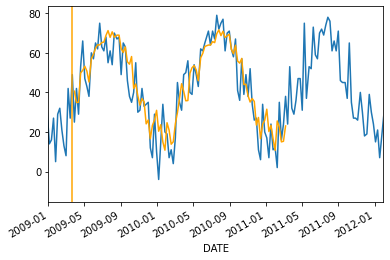

Timestamp('2005-05-21 00:00:00')

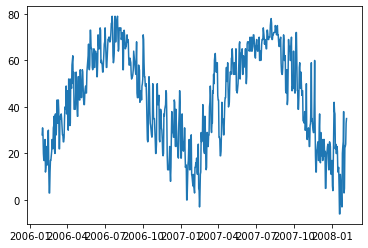

In [483]:
plt.plot(df_tot["DATE"].iloc[255:255+365*2],
    df_tot["TMIN"].iloc[255:255+365*2])

In [465]:
df_tot["DATE"].iloc[255:255+365*2]

426    2006-01-31
427    2006-02-01
428    2006-02-02
429    2006-02-03
430    2006-02-04
          ...    
1153   2008-02-01
1154   2008-02-02
1155   2008-02-03
1156   2008-02-04
1157   2008-02-05
Name: DATE, Length: 730, dtype: datetime64[ns]

In [446]:
df_tot#.iloc[255]
df_tot.iloc[1711]
# days
new_date = df_tot["DATE"].iloc[0] + pd.Timedelta(days=255+365*5)

In [450]:
df_tot[df_tot["DATE"] == new_date]

,DATE,TMIN,TMAX,TOBS,PRCP,SNOW,SNWD,year,doy,year_offset,doy_offset
2240,2011-01-30,21.0,46.0,21.0,0.0,0.0,0.0,2011,30,2010-2011,30


In [363]:
# ranges

In [364]:
# df_tot

In [346]:
# len(df_tot["TMIN"].values[ranges[i][0]:ranges[i][1]:7])

In [99]:
results_list = []
for i in range(N-lag_years):
    model=SARIMAX(df_tot["TMIN"].values[ranges[i][0]:ranges[i][1]:7],order=(1,1,1),seasonal_order=(1,1,1,52))
    results=model.fit()
    results_list.append(results)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93236D+00    |proj g|=  1.62946D-01

At iterate    5    f=  2.82698D+00    |proj g|=  2.69683D-02

At iterate   10    f=  2.79412D+00    |proj g|=  1.52458D-03

At iterate   15    f=  2.79368D+00    |proj g|=  8.38111D-03

At iterate   20    f=  2.79320D+00    |proj g|=  7.45634D-04

At iterate   25    f=  2.79310D+00    |proj g|=  1.34301D-03

At iterate   30    f=  2.79309D+00    |proj g|=  1.30808D-04

At iterate   35    f=  2.79309D+00    |proj g|=  1.95844D-05

At iterate   40    f=  2.79309D+00    |proj g|=  8.68424D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02568D+00    |proj g|=  1.91327D-01


 This problem is unconstrained.



At iterate    5    f=  2.92316D+00    |proj g|=  2.56610D-02

At iterate   10    f=  2.88906D+00    |proj g|=  6.84064D-03

At iterate   15    f=  2.88724D+00    |proj g|=  3.06388D-03

At iterate   20    f=  2.88692D+00    |proj g|=  3.69264D-03

At iterate   25    f=  2.88680D+00    |proj g|=  1.61258D-03

At iterate   30    f=  2.88672D+00    |proj g|=  1.32017D-03

At iterate   35    f=  2.88670D+00    |proj g|=  2.83170D-04

At iterate   40    f=  2.88670D+00    |proj g|=  2.24531D-05

At iterate   45    f=  2.88670D+00    |proj g|=  1.21315D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     57   

 This problem is unconstrained.



At iterate    5    f=  2.97490D+00    |proj g|=  2.51438D-02

At iterate   10    f=  2.95404D+00    |proj g|=  2.68578D-03

At iterate   15    f=  2.95383D+00    |proj g|=  4.93586D-03

At iterate   20    f=  2.95339D+00    |proj g|=  1.95069D-03

At iterate   25    f=  2.95334D+00    |proj g|=  3.88347D-04

At iterate   30    f=  2.95333D+00    |proj g|=  1.27499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     38      1     0     0   9.393D-06   2.953D+00
  F =   2.9533306981604959     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.97367D+00    |proj g|=  2.63740D-02

At iterate   10    f=  2.92039D+00    |proj g|=  2.07008D-02

At iterate   15    f=  2.91024D+00    |proj g|=  2.24117D-02

At iterate   20    f=  2.90918D+00    |proj g|=  3.24067D-04

At iterate   25    f=  2.90905D+00    |proj g|=  9.02126D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   8.987D-06   2.909D+00
  F =   2.9090454323410175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.91418D+00    |proj g|=  1.29426D-02

At iterate   10    f=  2.89901D+00    |proj g|=  3.02063D-03

At iterate   15    f=  2.89865D+00    |proj g|=  4.26013D-04

At iterate   20    f=  2.89850D+00    |proj g|=  3.04213D-03

At iterate   25    f=  2.89758D+00    |proj g|=  2.42748D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     37      1     0     0   2.355D-05   2.898D+00
  F =   2.8975443770658682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.88190D+00    |proj g|=  5.59921D-02

At iterate   10    f=  2.86428D+00    |proj g|=  6.34162D-03

At iterate   15    f=  2.86111D+00    |proj g|=  6.57201D-03

At iterate   20    f=  2.86087D+00    |proj g|=  3.19364D-03

At iterate   25    f=  2.86067D+00    |proj g|=  1.84102D-03

At iterate   30    f=  2.86062D+00    |proj g|=  3.57498D-04

At iterate   35    f=  2.86061D+00    |proj g|=  5.44868D-04

At iterate   40    f=  2.86060D+00    |proj g|=  1.10658D-04

At iterate   45    f=  2.86060D+00    |proj g|=  5.66199D-05

At iterate   50    f=  2.86060D+00    |proj g|=  4.87710D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09283D+00    |proj g|=  2.74592D-01

At iterate    5    f=  3.00668D+00    |proj g|=  2.20057D-02

At iterate   10    f=  2.94746D+00    |proj g|=  7.04402D-03

At iterate   15    f=  2.94405D+00    |proj g|=  1.92747D-02

At iterate   20    f=  2.94314D+00    |proj g|=  1.77318D-04

At iterate   25    f=  2.94314D+00    |proj g|=  3.86880D-04

At iterate   30    f=  2.94313D+00    |proj g|=  2.61245D-04

At iterate   35    f=  2.94313D+00    |proj g|=  3.03780D-04

At iterate   40    f=  2.94313D+00    |proj g|=  1.14156D-04

At iterate   45    f=  2.94313D+00    |proj g|=  2.92128D-05


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.94313D+00    |proj g|=  7.38474D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   7.385D-05   2.943D+00
  F =   2.9431321959383179     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13085D+00    |proj g|=  2.67008D-01


 This problem is unconstrained.



At iterate    5    f=  3.04852D+00    |proj g|=  1.75030D-02

At iterate   10    f=  2.98558D+00    |proj g|=  6.22328D-02

At iterate   15    f=  2.97878D+00    |proj g|=  6.94020D-03

At iterate   20    f=  2.97599D+00    |proj g|=  1.14868D-03

At iterate   25    f=  2.97598D+00    |proj g|=  1.10392D-03

At iterate   30    f=  2.97594D+00    |proj g|=  2.24944D-03

At iterate   35    f=  2.97592D+00    |proj g|=  2.86933D-04

At iterate   40    f=  2.97592D+00    |proj g|=  5.66574D-05

At iterate   45    f=  2.97592D+00    |proj g|=  2.28936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     54   

 This problem is unconstrained.



At iterate    5    f=  2.89184D+00    |proj g|=  3.37725D-02

At iterate   10    f=  2.88709D+00    |proj g|=  8.73576D-03

At iterate   15    f=  2.88304D+00    |proj g|=  7.14123D-03

At iterate   20    f=  2.87920D+00    |proj g|=  1.72065D-02

At iterate   25    f=  2.87818D+00    |proj g|=  1.51651D-03

At iterate   30    f=  2.87810D+00    |proj g|=  4.55960D-04

At iterate   35    f=  2.87809D+00    |proj g|=  2.63869D-04

At iterate   40    f=  2.87809D+00    |proj g|=  8.12971D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     48      1     0     0   7.925D-06   2.878D+00
  F =   2.87808550017

 This problem is unconstrained.



At iterate    5    f=  2.90420D+00    |proj g|=  5.95635D-02

At iterate   10    f=  2.87063D+00    |proj g|=  5.54243D-03

At iterate   15    f=  2.86996D+00    |proj g|=  2.06816D-03

At iterate   20    f=  2.86981D+00    |proj g|=  1.91020D-03

At iterate   25    f=  2.86976D+00    |proj g|=  9.16875D-04

At iterate   30    f=  2.86971D+00    |proj g|=  9.64618D-04

At iterate   35    f=  2.86969D+00    |proj g|=  2.17655D-03

At iterate   40    f=  2.86968D+00    |proj g|=  9.51069D-05

At iterate   45    f=  2.86968D+00    |proj g|=  1.12645D-04


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.86968D+00    |proj g|=  1.16621D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   1.166D-04   2.870D+00
  F =   2.8696768427304091     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03229D+00    |proj g|=  2.15294D-01

At iterate    5    f=  2.93234D+00    |proj g|=  1.17918D-01

At iterate   10    f=  2.90970D+00    |proj g|=  7.24032D-03

At iterate   15    f=  2.90871D+00    |proj g|=  2.49603D-03

At iterate   20    f=  2.90850D+00    |proj g|=  2.25350D-03

At iterate   25    f=  2.90842D+00    |proj g|=  1.48926D-04

At iterate   30    f=  2.90840D+00    |proj g|=  2.70290D-04

At iterate   35    f=  2.90840D+00    |proj g|=  4.29124D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03771D+00    |proj g|=  2.57451D-01

At iterate    5    f=  2.93367D+00    |proj g|=  2.57301D-02

At iterate   10    f=  2.91415D+00    |proj g|=  1.31044D-03

At iterate   15    f=  2.91409D+00    |proj g|=  2.21121D-04

At iterate   20    f=  2.91408D+00    |proj g|=  2.62306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   1.375D-05   2.914D+00
  F =   2.9140834240069915     

CONVERG

### asdf

Text(0.5, 0, 'weeks')

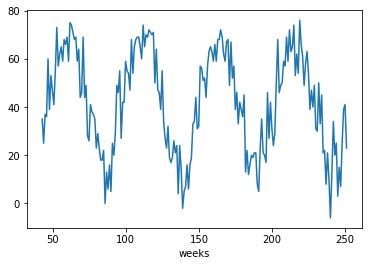

In [381]:
TMIN_weekly = df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7]
days = np.arange(ranges[0][0],ranges[0][1],7)
weeks = days/7
plt.plot(weeks,TMIN_weekly)
plt.xlabel("weeks")

In [382]:
len(TMIN_weekly)

209

In [383]:
ranges

[(300, 1760),
 (665, 2125),
 (1030, 2490),
 (1395, 2855),
 (1760, 3220),
 (2125, 3585),
 (2490, 3950),
 (2855, 4315),
 (3220, 4680),
 (3585, 5045),
 (3950, 5410),
 (4315, 5775)]

In [384]:
ranges[i][1]/7

251.42857142857142

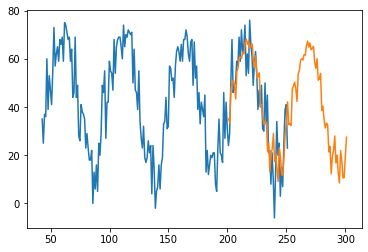

In [386]:
i=0
start = ranges[i][1]//7-50
end = ranges[i][1]//7+50

TMIN_weekly = df_tot["TMIN"].values[ranges[i][0]:ranges[i][1]:7]
days = np.arange(ranges[i][0],ranges[i][1],7)
weeks = days/7

test = results_list[i].predict(start=start,end=end,dynamic=True)
plt.plot(weeks,TMIN_weekly)
plt.plot(np.arange(start,end+0.5,1),test)

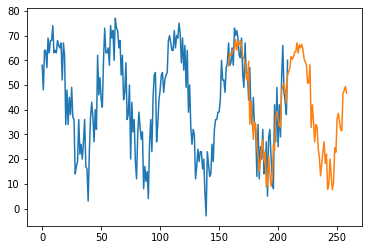

In [310]:
# plt.plot(test)
# start,end
len(test),len(np.arange(start,end+0.5,1))


In [259]:
start

730

In [146]:
# plt.plot(days,df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7])


In [143]:
days = np.arange(ranges[0][0],ranges[0][1],7)

In [203]:
ranges[0]

(0, 1460)

In [238]:
# results_list
# for i in range(N-lag_years):
i=0
start = ranges[i][0]
end = ranges[i][1]
test = results_list[i].predict(start=start,end=end,dynamic=True)
days = np.arange(ranges[i][0],end,7)

In [239]:
start,end
# plt.plot(test)

(0, 1460)

In [194]:
start, end
end-start, len(test)

(1460, 1461)

(209, 1461)

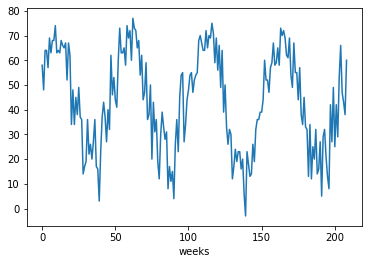

In [266]:
# plt.plot(df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7])
# plt.plot(df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7])

# len(df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7]),len(np.arange(ranges[0][0],ranges[0][1],7))
i = 0
days_train = np.arange(ranges[i][0],ranges[i][1],7)/7
TMIN_train = df_tot["TMIN"].values[ranges[i][0]:ranges[i][1]:7]
plt.plot(days_train,TMIN_train)
plt.xlabel("weeks")

days_pred = np.arange(ranges[i][0]/7,ranges[i][1]/7,1)
# plt.plot(days_pred,test)
# plt.plot(test)
len(days_pred), len(test)

In [120]:
len(test)
len(np.arange(start,end+1,1))

151

In [123]:
start,end

(1410, 1560)

In [140]:
# plt.plot(days,np.arange(start,end+1,1),vczx)
# plt.plot(days,df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7])
# plt.plot(np.arange(start,end+1,1),test)
# plt.plot(test)
# plt.plot(df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7])

In [102]:
# model=SARIMAX(df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7],order=(1,1,1),seasonal_order=(1,1,1,52))
# results=model.fit()

In [124]:
start = ranges[0][1]-50
end=ranges[0][1]+100
vczx = results.predict(start=start,end=end,dynamic=True)

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [127]:
start,end,ranges

(1410,
 1560,
 [(0, 1460),
  (365, 1825),
  (730, 2190),
  (1095, 2555),
  (1460, 2920),
  (1825, 3285),
  (2190, 3650),
  (2555, 4015),
  (2920, 4380),
  (3285, 4745),
  (3650, 5110),
  (4015, 5475)])

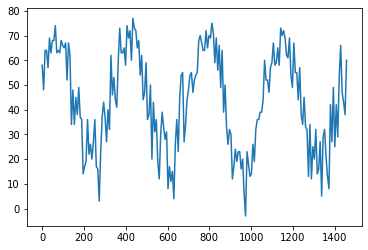

In [98]:
x = np.arange(0,len(df_tot),1)
# plt.plot(x,df_tot["TMIN"])
# plt.plot(days,np.arange(start,end+1,1),vczx)
plt.plot(days,df_tot["TMIN"].values[ranges[0][0]:ranges[0][1]:7])

In [76]:
test_result = adfuller(df_tot["TMIN"])

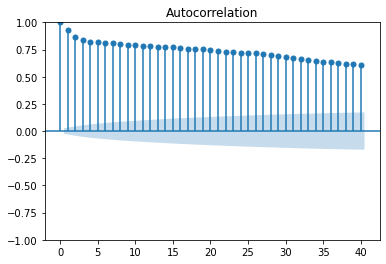

In [2229]:
plot_acf(df_tot["TMIN"],lags=40) #q=1 or 0
plt.show()

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


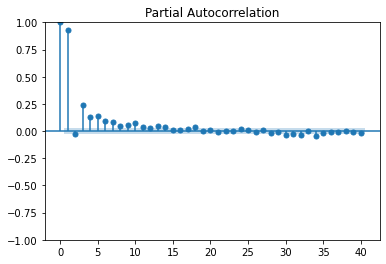

In [2227]:
plot_pacf(df_tot["TMIN"],lags=40) #AR value should be 1
plt.show()

In [2192]:
# for value,label in zip(test_result):
    # print(value)

test_result[1]

3.847400592807438e-07

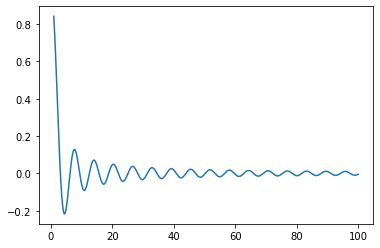

In [2195]:
plt.plot(df_tot["TMIN"])

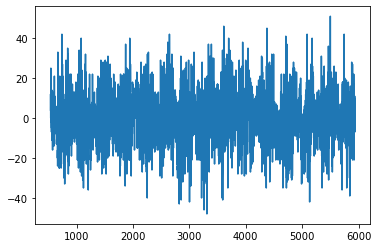

In [2194]:
fdsa = (df_tot["TMIN"]-df_tot["TMIN"].shift(365)).dropna()
# plt.plot(df_tot["TMIN"])
plt.plot(fdsa)
# adfuller(fdsa)

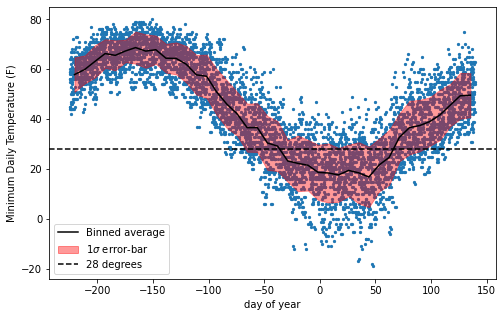

In [2139]:
fig,ax = plt.subplots(1,figsize=(8,5))
plt.scatter(df_tot["doy_offset"],df_tot["TMIN"].values,s=5)
plt.plot(bin_centers,binned_TMIN,color='k',label="Binned average")
plt.fill_between(bin_centers,
                binned_TMIN-binned_TMIN_std,
                binned_TMIN+binned_TMIN_std,
                alpha=0.4,color='red',label=r'$1\sigma$ error-bar')
plt.axhline(28,ls='dashed',color='k',label="28 degrees")
plt.xlabel("day of year")
plt.ylabel("Minimum Daily Temperature (F)");
plt.legend();

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

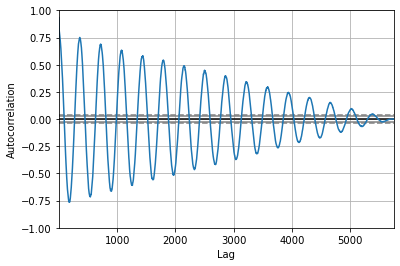

In [2140]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_tot['TMIN'])


In [2143]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2150]:
# fig,ax = plt.subplots(1,figsize=(8,5))
# plt.scatter(np.asarray(df_cleaned["doy"],int),df_cleaned["TMIN"].values,s=5)
# plt.plot(np.asarray(result.doy,int),result["mean"],color='k',label='average over years')
# plt.plot(output_params['fitfunc'](result.doy),color='red')
# plt.xlabel("day of year")
# plt.ylabel("Minimum Daily Temperature (F)")
# plt.legend()
np.sum(np.isnan(df_cleaned["TMIN"].values))


0

In [2157]:
mod = SARIMAX(df_cleaned["TMIN"].values, trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

predict = res.get_prediction()
predict_ci = predict.conf_int()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6132
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -20531.428
Date:                Fri, 27 Sep 2024   AIC                          41070.857
Time:                        11:01:00   BIC                          41097.741
Sample:                             0   HQIC                         41080.183
                               - 6132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.009      0.031      0.976      -0.018       0.018
ar.L1          0.6447      0.015     43.102      0.000       0.615       0.674
ma.L1         -0.8996      0.009   -102.551      0.0

(0.0, 100.0)

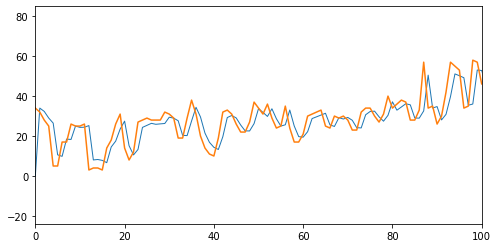

In [2169]:
plt.figure(figsize=(8,4))
plt.plot(predict.predicted_mean,lw=1)
plt.plot(df_cleaned["TMIN"].values)
plt.xlim(0,100)
# df_cleaned["TMIN"].values-predict.predicted_mean

The average last frost day is 98.5 +/- 12.7


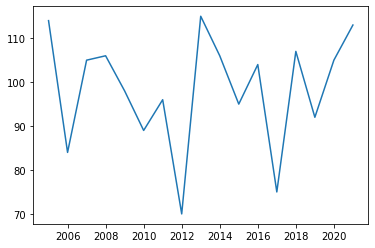

In [1445]:
mask = (df_cleaned["TMIN"]<=28) & (df_cleaned['doy']<200)
filtered_df = df_cleaned[mask]
yearly_last_frost_by_doy = filtered_df.groupby('year')['doy'].max()
year_list = np.asarray(yearly_last_frost_by_doy.index,int)
plt.plot(year_list,yearly_last_frost_by_doy.values)
avg_last_frost_day = np.mean(yearly_last_frost_by_doy.values)
std_last_frost_day = np.std(yearly_last_frost_by_doy.values)
print(f"The average last frost day is {avg_last_frost_day:.1f} +/- {std_last_frost_day:.1f}")

In [1116]:
# mask = (doy_temp_stats["mean"]<=28)&(doy_temp_stats["mean"]>0)
# pred_last_day = np.max(doy_temp_stats['doy_offset'][mask])

In [1092]:
# doy_temp_stats[doy_temp_stats['doy_offset'] == pred_last_day]

,doy,mean,std,doy_offset
65,66,26.5625,9.423154,66


<!-- There are a lot of temperature fluctuations 
 -->
Can we put any uncertainty on this measurement? Standard deviation would be convenient. But it only makes sense to do that for normal distributions.

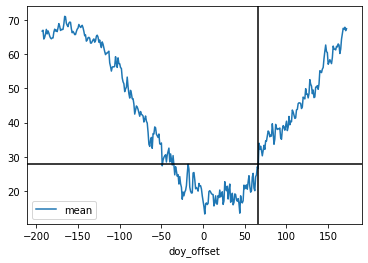

In [1087]:
# doy_temp_stats.plot("doy_offset","mean")
# plt.axvline(pred_last_day,color='k')
# plt.axhline(28,color='k')


In [1088]:
# mask = (doy_temp_stats["mean"]-doy_temp_stats["std"] <= 28) & (doy_temp_stats['doy']<200)

# doy_temp_stats["std"]

There is an 84.0% chance that the last night with a minimum temperature of 28 degrees is on or before the 105th doy.
The 105th day of 2025 is Tuesday, April 15.


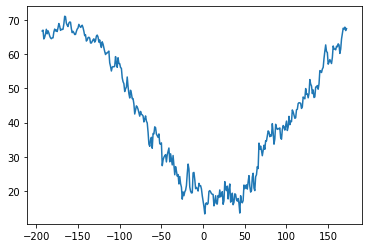

In [1072]:
plt.plot(doy_temp_stats['doy_offset'],doy_temp_stats["mean"])#-doy_temp_stats["std"])
# plt.axhline(28)
mask = (doy_temp_stats["mean"]-doy_temp_stats["std"] <= 28) & (doy_temp_stats['doy']<200)
pred_last_day = np.max(doy_temp_stats['doy'][mask])
prob = 100-(100-68)/2
print(f"There is an {prob}% chance that the last night with a minimum temperature of "+
      f"28 degrees is on or before the {pred_last_day}th doy.")
print("The 105th day of 2025 is Tuesday, April 15.")

In [974]:
# df_tot["doy"]
#f'{2010}-06-20'
# .dt.strftime('%j')

In [881]:
# df_cleaned

In [1561]:
# year_list = np.unique(df_cleaned.year) # == "2005"
# solstice_doy = 170
# df_tot = pd.concat([df_cleaned[(df_cleaned.year == year_list[0]) & 
#            (df_cleaned.doy>365-solstice_doy)],
#           df_cleaned[(df_cleaned.year == year_list[1]) & 
#            (df_cleaned.doy<solstice_doy)]
#           ], ignore_index=True).reset_index(names="doy_offset")
# df_tot["year_offset"] = year_list[0]+"-"+year_list[1]
# for i in range(1,len(year_list)-1):
#     df_i = pd.concat([df_cleaned[(df_cleaned.year == year_list[i]) & 
#                (df_cleaned.doy>365-solstice_doy)],
#               df_cleaned[(df_cleaned.year == year_list[i+1]) & 
#                (df_cleaned.doy<solstice_doy)]
#               ], ignore_index=True).reset_index(names="doy_offset")
#     df_i["year_offset"] = year_list[i]+"-"+year_list[i+1]
#     df_tot = pd.concat([df_tot,df_i])
# year_offset_list = np.unique(df_tot["year_offset"])

In [904]:
# df_asdf = df_tot[df_tot["year_offset"] == year_offset_list[6]]

# plt.plot(df_asdf["TMIN"])
# # df_asdf.iloc[-4]

In [779]:
df_asdf

,DATE,TMIN,TMAX,TOBS,PRCP,SNOW,SNWD,year,doy,year_offset
0,2005-07-15,67.0,91.0,70.0,0.00,0.0,0.0,2005,196,2005-2006
1,2005-07-16,68.0,94.0,68.0,0.00,0.0,0.0,2005,197,2005-2006
2,2005-07-17,68.0,91.0,72.0,0.00,0.0,0.0,2005,198,2005-2006
3,2005-07-18,68.0,86.0,68.0,0.83,0.0,0.0,2005,199,2005-2006
4,2005-07-19,69.0,84.0,70.0,0.05,0.0,0.0,2005,200,2005-2006
...,...,...,...,...,...,...,...,...,...,...
334,2006-06-14,59.0,87.0,59.0,0.00,0.0,0.0,2006,165,2005-2006
335,2006-06-15,71.0,90.0,71.0,0.00,0.0,0.0,2006,166,2005-2006
336,2006-06-16,67.0,91.0,73.0,0.00,0.0,0.0,2006,167,2005-2006
337,2006-06-17,65.0,83.0,67.0,0.00,0.0,0.0,2006,168,2005-2006


In [444]:
result = df_cleaned.groupby('doy')['TMIN'].agg(['mean', 'std']).reset_index()
result

,doy,mean,std
0,1,16.529412,12.062948
1,2,14.411765,11.646130
2,3,16.941176,13.050242
3,4,17.058824,10.755641
4,5,15.411765,10.518192
...,...,...,...
361,362,22.941176,10.034133
362,363,21.611111,9.804794
363,364,20.888889,10.075532
364,365,20.277778,9.651611


### Solution 1: Simplest
In this first solution

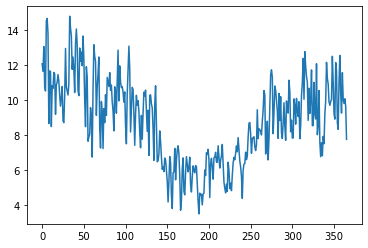

In [554]:
plt.plot(result["std"])

In [549]:
import scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters 
    "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   
    # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, 
            "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

mask = np.isfinite(df_cleaned["TMIN"])
output_params = fit_sin(df_cleaned["doy"][mask].values,df_cleaned["TMIN"][mask].values)


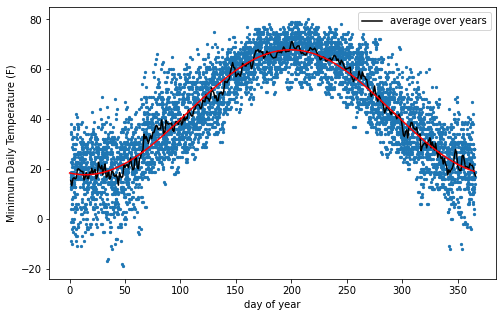

In [1067]:
fig,ax = plt.subplots(1,figsize=(8,5))
plt.scatter(np.asarray(df_cleaned["doy"],int),df_cleaned["TMIN"].values,s=5)
plt.plot(np.asarray(result.doy,int),result["mean"],color='k',label='average over years')
plt.plot(output_params['fitfunc'](result.doy),color='red')
plt.xlabel("day of year")
plt.ylabel("Minimum Daily Temperature (F)")
plt.legend()


There is an 84.0% that the last night with a minimum temperature of 28 degrees is on or before the 105th doy.
The 105th day of 2025 is Tuesday, April 15.


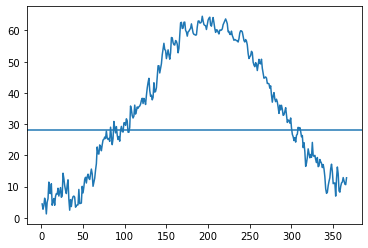

In [572]:
plt.plot(result['doy'],result["mean"]-result["std"])
plt.axhline(28)
mask = (result["mean"]-result["std"] <= 28) & (result['doy']<200)
pred_last_day = np.max(result['doy'][mask])
prob = 100-(100-68)/2
print(f"There is an {prob}% chance that the last night with a minimum temperature of "+
      f"28 degrees is on or before the {pred_last_day}th doy.")
print("The 105th day of 2025 is Tuesday, April 15.")

### variations in LDOF?
last day of frost (28 degrees)

In [501]:
# plt.plot(np.asarray(result.doy,int),df_cleaned["TMIN"].values / result["mean"]-1,
#          color='k',label='average over years')
asdf = np.asarray(df_cleaned["doy"],int)
asdf
# dict({[1,2],['a','b']})
result[["doy","mean"]]
df_merged = pd.merge(df_cleaned,result,on='doy')
df_merged['TMIN_flucs'] = df_merged['TMIN'] / df_merged['mean']-1

Text(0.5, 1.0, 'TMIN fluctuations from mean')

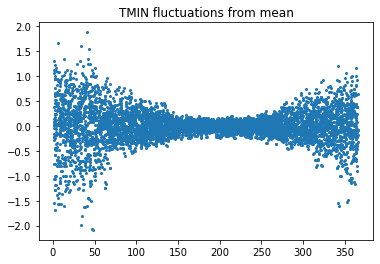

In [504]:
plt.scatter(df_merged["doy"],df_merged['TMIN_flucs'],s=4)
plt.title("TMIN fluctuations from mean")
# plt.xlim(0,200)

Text(0.5, 1.0, '|T_min - T_avg|')

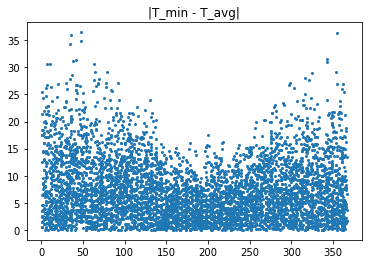

In [505]:
plt.scatter(df_merged["doy"],np.abs(df_merged['TMIN']-df_merged['mean']),s=4)
plt.title("|T_min - T_avg|")

Text(0.5, 1.0, 'T_max - T_min')

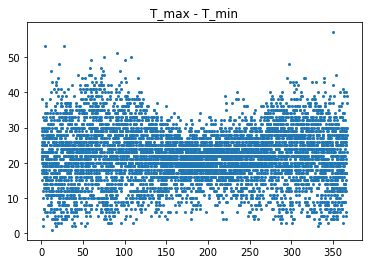

In [513]:
plt.scatter(df_merged["doy"],df_merged['TMAX']-df_merged['TMIN'],s=4)
plt.title("T_max - T_min")

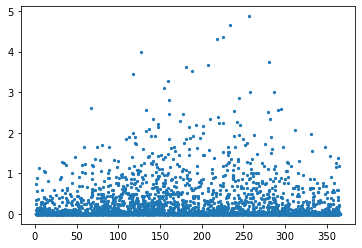

In [522]:
plt.scatter(df_merged["doy"], df_merged["PRCP"],s=5)
# plt.scatter(df_merged["doy"], df_merged["TMIN"],s=5)
# plt.scatter(df_merged["doy"], df_merged["PRCP"],s=5)

In [506]:
df_cleaned['test'] = df_cleaned["DATE"]

Last day that TMIN <= 28 degrees: Day 84


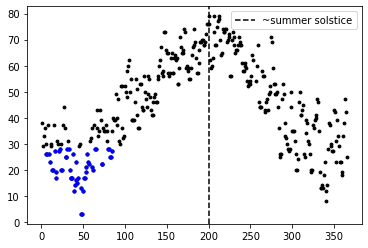

In [507]:
test = df_cleaned[df_cleaned["year"]=="2006"]
days = np.asarray(test["doy"],int)
mask1 = (test["TMIN"]<=28)  
mask2 = (days<200)
plt.scatter(days,test["TMIN"],s=8,color='k')
plt.scatter(days[mask1&mask2],test["TMIN"][mask1&mask2],s=10,color='blue')
plt.axvline(200,label="~summer solstice",color='k',ls='--')
plt.legend()
last_frost = test['doy'][mask1&mask2].iloc[-1]
print(f"Last day that TMIN <= 28 degrees: Day {last_frost}")

### Feature extraction

Things to try:
- daily minimum temperature. This is likely the most important because it is the same quantity as the prediction
- daily maximum temperature. 
- daily temperature variation (TMAX-TMIN)
- 

In [454]:
# # test[(test["doy"]>last_frost-7 114]
# last_frost
# test["doy"]==114
# last_frost
# # test['doy'].reset_index(drop=True)[last_frost-7:last_frost]

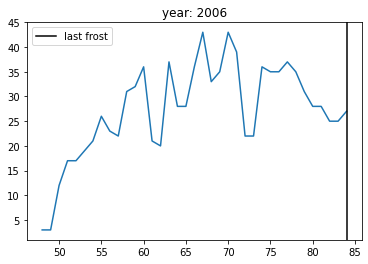

In [555]:
mask_month_before = (test['doy']>last_frost-37)&(test['doy']<=last_frost)
test2 = test[mask_month_before]
plt.title("year: 2006")
plt.plot(test2["doy"],test2["TMIN"])
plt.axvline(last_frost,color='k', label='last frost')
plt.legend(loc='upper left')

The average last frost day is 98.5 +/- 12.7


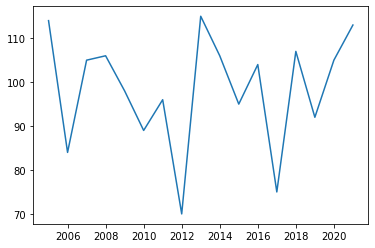

In [578]:
mask = (df_cleaned["TMIN"]<=28) & (df_cleaned['doy']<200)
filtered_df = df_cleaned[mask]
yearly_last_frost_by_doy = filtered_df.groupby('year')['doy'].max()
year_list = np.asarray(yearly_last_frost_by_doy.index,int)
plt.plot(year_list,yearly_last_frost_by_doy.values)
avg_last_frost_day = np.mean(yearly_last_frost_by_doy.values)
std_last_frost_day = np.std(yearly_last_frost_by_doy.values)
print(f"The average last frost day is {avg_last_frost_day:.1f} +/- {std_last_frost_day:.1f}")

array([2012, 2017, 2006, 2010, 2019, 2015, 2011, 2009, 2016, 2007, 2020,
       2008, 2014, 2018, 2021, 2005, 2013])

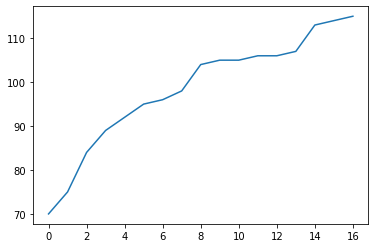

In [604]:
LDOF_yearly_sorted = yearly_last_frost_by_doy.sort_values().values
years_sorted = np.asarray(yearly_last_frost_by_doy.sort_values().keys(),int)
plt.plot(LDOF_yearly_sorted)
years_sorted

24.27536231884058
Last day that TMIN <= 28 degrees: Day 70


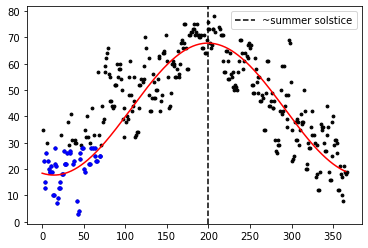

In [1069]:
test = df_cleaned[df_cleaned["year"]=="2012"]
days = np.asarray(test["doy"],int)
mask1 = (test["TMIN"]<=28)  
mask2 = (days<200)
plt.scatter(days,test["TMIN"],s=8,color='k')
plt.scatter(days[mask1&mask2],test["TMIN"][mask1&mask2],s=10,color='blue')
plt.axvline(200,label="~summer solstice",color='k',ls='--')
plt.legend()
last_frost = test['doy'][mask1&mask2].iloc[-1]
plt.plot(output_params['fitfunc'](result.doy),color='red')

print(np.mean(test["TMIN"][test['doy']<70]))
print(f"Last day that TMIN <= 28 degrees: Day {last_frost}")

21.08695652173913
Last day that TMIN <= 28 degrees: Day 115


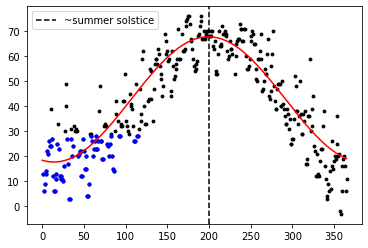

In [1068]:
test = df_cleaned[df_cleaned["year"]=="2013"]
days = np.asarray(test["doy"],int)
mask1 = (test["TMIN"]<=28)  
mask2 = (days<200)
plt.scatter(days,test["TMIN"],s=8,color='k')
plt.scatter(days[mask1&mask2],test["TMIN"][mask1&mask2],s=10,color='blue')
plt.axvline(200,label="~summer solstice",color='k',ls='--')
plt.legend()
last_frost = test['doy'][mask1&mask2].iloc[-1]

plt.plot(output_params['fitfunc'](result.doy),color='red')

print(np.mean(test["TMIN"][test['doy']<70]))
print(f"Last day that TMIN <= 28 degrees: Day {last_frost}")

Goal is to predict the last <=28 degree day of the spring

A simpler problem may be to predict the temperature in 7 days given the previous 30 days.

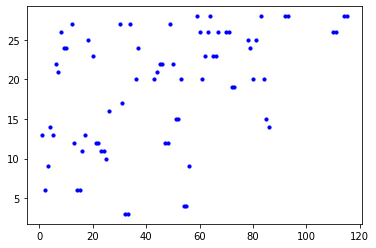

In [622]:
plt.scatter(days[mask1&mask2],test["TMIN"][mask1&mask2],s=10,color='blue')


In [202]:
# df_cleaned["YEAR"] = pd.DatetimeIndex(df_cleaned['DATE']).values

In [228]:
df_cleaned

,DATE,TMIN,TMAX,TOBS,PRCP,SNOW,SNWD
0,2004-12-01,19.0,43.0,19.0,0.04,0.5,0.0
1,2004-12-02,22.0,47.0,20.0,0.00,0.0,0.0
2,2004-12-03,24.0,48.0,24.0,0.00,0.0,0.0
3,2004-12-04,28.0,61.0,28.0,0.00,0.0,0.0
4,2004-12-05,37.0,48.0,37.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...
6225,2021-12-27,40.0,65.0,42.0,0.00,0.0,0.0
6226,2021-12-28,38.0,47.0,42.0,0.17,0.0,0.0
6227,2021-12-29,20.0,59.0,21.0,0.11,0.0,0.0
6228,2021-12-30,21.0,34.0,29.0,0.00,0.0,0.0


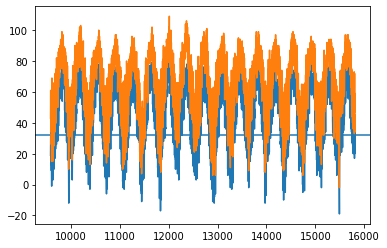

In [206]:
plt.plot(df["TMIN"])
plt.axhline(32)
plt.plot(df["TMAX"])
# sum(df["DATE"] == "2014-03-03")

In [55]:

np.sum(np.isfinite(df[mask]["TMAX"]))/np.sum(mask)

0.6076953201488153

In [59]:
df.keys()

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'DAPR',
       'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES',
       'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TMAX',
       'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES',
       'WESD', 'WESD_ATTRIBUTES', 'WESF', 'WESF_ATTRIBUTES', 'WT01',
       'WT01_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES',
       'WT05', 'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES', 'WT11',
       'WT11_ATTRIBUTES'],
      dtype='object')